In [1]:
# 전이학습
# 파이썬을 학습--> 파이썬과 유사한 다른언어를 배울때 좀더 빠르고 쉽게 배울수있음
# 개념과 사용법을 공유하기때문에 가능.... --> 딥러닝에서도 동일하게 적용
# 자연영상(cifar10) 학습한 신경망을.. 새나 개를 분류... 자율주행에서 차선인식.... 
# 다른 도메인의 데이터로 학습한 모델을 다른 도메인의 데이터를 인식하는데 활용하여 성능을 개선
# 데이터가 부족해서 성능을 보장할 수 없는 상황에 주로 이용
# cub200-2011 -> 200종의 새 영상 분류.... 부류별로 60장 .. overfit(과적합, 과대적합, 과잉적합) 발생
# ImageNet 으로 예비학습 된 모델을 cub200-2011로 전이하는 전이학습

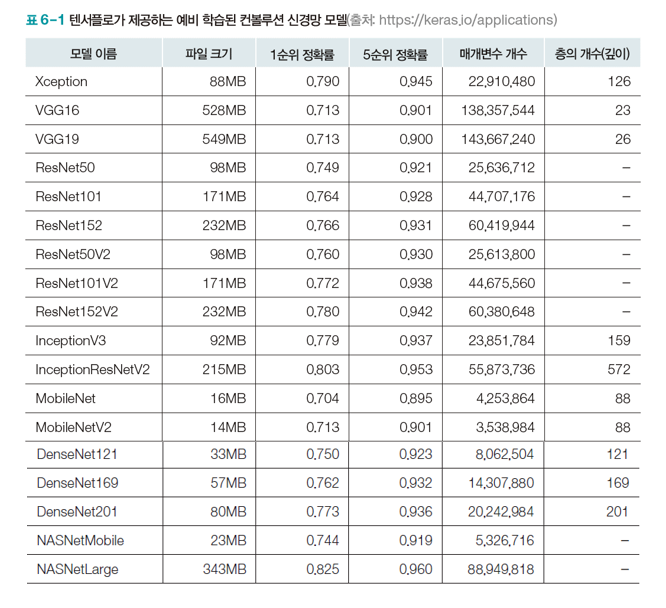

In [2]:
#텐서플로우는 이미 예비 학습된 컨볼류션 신경망 모델을 가지고있음
from IPython.display import Image
Image("https://raw.githubusercontent.com/bigdataleeky/python/main/image/56.PNG", width=500)

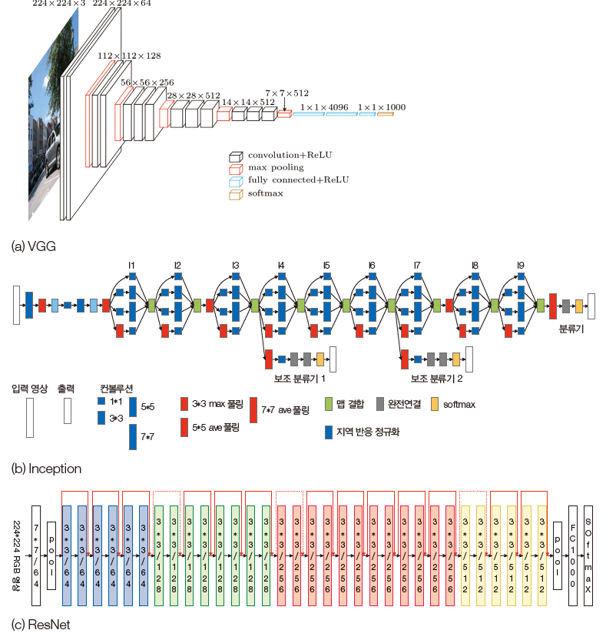

In [3]:
# 주로많이 사용되는 예비학습
# VGG : 3x3 마스크 
#inception(GoogleNet) : 네트웍속의 네크웍(NIN)  구현
# ResNet : 잔류 학습
Image("https://raw.githubusercontent.com/bigdataleeky/python/main/image/57.PNG", width=500)

In [4]:
#ImageNet으로 학습한 ResNeT 모델을 새 품종을 인식하는 문제로 전이
# 데이터는 이미 제공하고있는 cub200-2011을 사용(대략 12000)
# 미세분류 문제
# 부류내 변화가 크고(품종이 많다) 부류간 유사도가 큼

In [5]:
!unzip -qq "/content/drive/MyDrive/CUB200.zip"

In [6]:
train_folder = '/content/train'
test_folder = '/content/test'

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
import os

In [17]:
class_reduce = 0.1 # 메모리 문제때문에 일부 데이터만 사용, 부류수를 줄여서 데이터량을 줄임
no_class = int(len(os.listdir(train_folder))*class_reduce)
no_class

20

In [42]:
from posix import listdir
# train 데이터중에 축소해서(class_reduce 비율) 사용 - 메모리문제때문에.. 코렙은 메모리 많이 사용하면 죽음
x_train = []; y_train = []
for i,class_name in  enumerate( os.listdir(train_folder)):  # 지정한 루트폴더내의 서브폴더들...
  if i < no_class:
    for fname in os.listdir(train_folder+'/'+class_name):  # 루트폴더+서브폴더에 있는 파일명(bird 이미지파일)
      img = image.load_img(train_folder+'/'+class_name+'/'+fname, target_size=(224,224))
      if len(img.getbands()) !=3:
        print("유효하지 않은 영상",class_name,fname)
        continue;
      x =image.img_to_array(img)
      x = preprocess_input(x)
      x_train.append(x)
      y_train.append(i)

In [43]:
x_train= np.array( x_train)
y_train = np.array( y_train)
x_train.shape, y_train.shape

((599, 224, 224, 3), (599,))

In [44]:
x_test = []; y_test = []
for i,class_name in  enumerate( os.listdir(test_folder)):  # 지정한 루트폴더내의 서브폴더들...
  if i < no_class:
    for fname in os.listdir(test_folder+'/'+class_name):  # 루트폴더+서브폴더에 있는 파일명(bird 이미지파일)
      img = image.load_img(test_folder+'/'+class_name+'/'+fname, target_size=(224,224))
      if len(img.getbands()) !=3:
        print("유효하지 않은 영상",class_name,fname)
        continue;
      x =image.img_to_array(img)
      x = preprocess_input(x)
      x_test.append(x)
      y_test.append(i)
x_test = np.array(x_test)
y_test = np.array(y_test)

x_test.shape,  y_test.shape

((576, 224, 224, 3), (576,))

In [45]:
y_train = tf.keras.utils.to_categorical(y_train,no_class)
y_test = tf.keras.utils.to_categorical(y_test,no_class)

In [46]:
base_model = ResNet50(weights='imagenet',include_top=False,input_shape=(224, 224, 3))
cnn = Sequential()
cnn.add(base_model)  # 기존 기 학습된(제공된) ResNete50이 사용한 신경망 구조를 copy하게됨
cnn.add(Flatten())
cnn.add(Dense(1024,activation='relu'))
cnn.add(Dense(no_class,activation='softmax'))

In [47]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((599, 224, 224, 3), (599, 20), (576, 224, 224, 3), (576, 20))

In [48]:
# Adam 0.00002 -> 미세조정방식으로 가장 낮은 학습률 설정해서 조금씩 증가시키면서 결과를 보려고함 - >하이퍼 파라메터  
cnn.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(0.00002),metrics=['accuracy'])
hist = cnn.fit(x_train,y_train,batch_size=16,epochs=10, validation_data=(x_test,y_test),verbose=1)

Epoch 1/10
38/38 [==============================] - 539s 14s/step - loss: 2.9259 - accuracy: 0.3205 - val_loss: 1.0522 - val_accuracy: 0.6823
Epoch 2/10
38/38 [==============================] - 535s 14s/step - loss: 0.0657 - accuracy: 0.9816 - val_loss: 1.2042 - val_accuracy: 0.7049
Epoch 3/10
38/38 [==============================] - 541s 14s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.0325 - val_accuracy: 0.7170
Epoch 4/10
13/38 [=========>....................] - ETA: 5:04 - loss: 8.7692e-04 - accuracy: 1.0000

KeyboardInterrupt: ignored

In [1]:
res = cnn.evaluate(x_test, y_test)
print(f"정확률= {res[1]*100}")
cnn.save('/content/drive/MyDrive/bird_cnn.h5')

# 전이학습에서 성능을 높이는 방법 -- 특정 도메인
# 미세조정 방식
   # 컨볼류션 층, 완전연결층에 가중치를 동시에 수정
   # 학습률을 낮게 유지해서 조금씩 수정
# 동결방식
  # 컨볼류션 층의 가중치를 동결해서 업데이트가 일어나지 않게 제한
  # base_model.trainable  =False
# CUB 데이터셋에 대해 실험한 결과 미세조정 방식이 우수함..

NameError: ignored

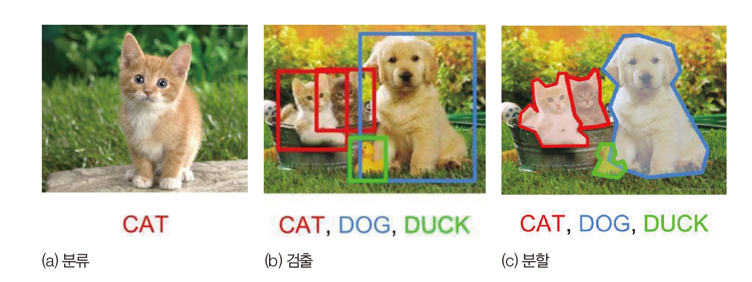

In [4]:
from IPython.display import Image
Image("https://raw.githubusercontent.com/bigdataleeky/python/main/image/58.PNG", width=500)
# 물체 검출
# 물체 검출을 위한 딥러닝 모델
# R-CNN
# Fast R-CNN
# Faster R-CNN
# YOLO(you only look once) --> ******

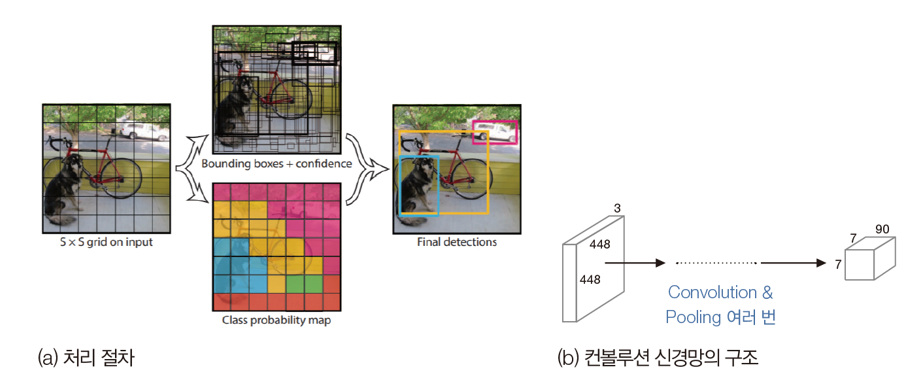

In [7]:
Image("https://raw.githubusercontent.com/bigdataleeky/python/main/image/59.PNG", width=800)
# 입력영상을 s*s 격자로 나눈 s제곱개의 격자 방에 각각에 대해 B개의 바운딩 박스를 생성
#-바운딩 박스는 (x,y,w,h,o)의 5개의 값으로 표현 o는 물에일 가능성)
# C=80개의 물체 부류
# S=7, B=2 -->79개 격자방 각각은 부류 정보를 표현하는 80-차원 벡터와 바운딩 박스 두개를 표현 하는 10차원 벡터를 가짐

In [8]:
# YOLOv3  

In [10]:
import numpy as np
import cv2

In [14]:
classes = []
with open('/content/coco.names.txt', 'r') as f:
  classes =  [line.strip() for line in f.readlines()]
  
print(classes)  

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [18]:
classes_size = len(classes)
colors =  np.random.uniform(0,255,size=(classes_size,3))
colors

array([[233.2759694 ,  80.4524452 , 155.89058334],
       [131.45547563, 144.36685952, 254.02087006],
       [ 70.37965054, 181.89208698, 124.19539505],
       [199.77103254,  94.16277561, 167.91680334],
       [  6.86683728, 157.71218802, 218.5550637 ],
       [177.68381626,  76.54508698, 250.09591797],
       [151.0684147 , 205.71682928,  84.59384229],
       [225.66421901, 152.95114349,  41.64987174],
       [ 59.71075111, 208.97368865, 254.04383955],
       [192.99497656, 239.59507398, 143.8993563 ],
       [ 31.51480115,  44.98851623, 242.48267168],
       [ 62.75719157, 249.75176086,  63.85609276],
       [ 16.18321755, 126.55954171,  73.65284155],
       [ 86.32889629,  20.81837343, 245.09962429],
       [226.26202856,  84.71993274,  49.58092363],
       [ 11.03207197, 150.05426214,  65.54695956],
       [ 65.85292837,  22.40601465, 254.02019831],
       [173.06741038, 226.32760877, 162.7359837 ],
       [222.53973103, 200.35061551, 110.61271704],
       [122.5776688 , 121.83746